## Dimensionality Reduction
* Two common dimensionality reduction techniques are PCA and auto-encoders. Those techniques are sensitive to scale, so it is important to standardize the data and make it unitless. For this purpose, cell viability and gene expression features are standardized with standard scaler. For evaluating information loss in different dimensionality reduction techniques, latent space dimensions are set to half of cell viability and gene expression dimensions.

## PCA
* PCA is a linear transformation that projects the data into another space, where vectors of projections are defined by variance of the data. PCA results can be evaluated with reconstruction error and cumulative percent variance.

## Auto-encoder
* Auto-encoders are neural networks used for reducing data into a low dimensional latent space. Most important features lie in this low dimensional latent space because they are capable of reconstructing it. Auto-encoders are slower and computationally expensive compared to PCA, and they are also prone to overfitting.

In [1]:
!pip3 install iterative-stratification

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers,regularizers,Sequential,backend,callbacks,optimizers,metrics, Model,losses
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.decomposition import PCA

In [3]:
# Importing data

train_features = pd.read_csv('/content/train_features.csv')
non_ctrl_val = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type'],axis=1)
train_targets_scored = pd.read_csv('/content/train_targets_scored.csv')
train_targets_scored = train_targets_scored.drop('sig_id',axis=1)
train_label = train_targets_scored.values

# Droping of training data with ctl_vehicle

train_features = train_features.iloc[non_ctrl_val]
train_label = train_label[non_ctrl_val]

# Importing test data

test_features = pd.read_csv('/content/test_features.csv')
test_features = test_features.drop(['sig_id'],axis=1)

In [4]:
# Label Encoding for categorical feature "cp_dose"

categorical = 'cp_dose'
le = preprocessing.LabelEncoder()
le.fit(train_features[categorical])
train_features[categorical] = le.transform(train_features[categorical])

# Transform categorical

test_features[categorical] = le.transform(test_features[categorical])

In [5]:
# Quantile Transformer for gene and cell features

scaler = preprocessing.QuantileTransformer(output_distribution='normal')

# Scaling of train data
data_train = scaler.fit_transform(train_features.iloc[:,2:])

# Scaling of test data
data_test = scaler.transform(test_features.drop('cp_type',axis=1).iloc[:,2:])

# Standard Scaling for Dose/Time

scaler = preprocessing.StandardScaler()

# Concatinating train & test feature

data_train =  np.concatenate((scaler.fit_transform(train_features.iloc[:,:2]),data_train),axis=1)
data_test =  np.concatenate((scaler.transform(test_features.drop('cp_type',axis=1).iloc[:,:2]),data_test),axis=1)

In [6]:
n_features = data_train.shape[1]
n_labels = train_label.shape[1]
n_train = data_train.shape[0]
n_test = data_test.shape[0]

In [7]:
# Autoencoder to create compressed features

# Cells feature i.e. 'c-'

c_f = train_features.columns.str.contains('c-')
cells_train = data_train[:,c_f]
cells_test = data_test[:,c_f]
dim_encd = 256
act = 'relu'
noise = 0.15
dropout = 0.1
class Autoencoder(Model):
    def __init__(self, num_inp, dim_encd):
        super(Autoencoder, self).__init__()
        # encoder function
        self.encoder = Sequential([             
            layers.BatchNormalization(),
            layers.Dropout(noise),
            layers.Dense(0.5*dim_encd,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.75*dim_encd,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(dim_encd,activation=act),
        ])
        # decoder function
        self.decoder = Sequential([
            layers.Dense(0.75*dim_encd,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.5*dim_encd,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(num_inp)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
cell_auto_encd = Autoencoder(c_f.sum(),dim_encd)
cell_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss='mse')
ae_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1E-5)
ae_early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=16, restore_best_weights=True)
def scheduler(epoch,lr):
    if epoch%32<17:
        lr += (0.3*1E-2)/16
    else:
        lr -= (0.3*1E-2)/16
    return lr

lr_scheduler = callbacks.LearningRateScheduler(scheduler)
hist = cell_auto_encd.fit(cells_train,cells_train,batch_size=128, verbose=1, 
                          validation_data = (cells_test,cells_test), epochs=256, 
                          shuffle=True, callbacks=[ae_early_stopping,lr_scheduler])

cell_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=5*1E-5), loss='mse')

cell_auto_encd.fit(cells_train,cells_train,batch_size=128, verbose=1, 
                   validation_data = (cells_test,cells_test), epochs=256, 
                   shuffle=True, callbacks=[ae_early_stopping,ae_reduce_lr])
cell_auto_encd.save('cell_fet_auto_encd')

Epoch 1/256
172/172 [==============================] - 6s 8ms/step - loss: 1.5707 - val_loss: 0.5953
Epoch 2/256
172/172 [==============================] - 1s 5ms/step - loss: 0.7109 - val_loss: 0.5181
Epoch 3/256
172/172 [==============================] - 1s 5ms/step - loss: 0.6398 - val_loss: 0.4759
Epoch 4/256
172/172 [==============================] - 1s 5ms/step - loss: 0.5815 - val_loss: 0.4366
Epoch 5/256
172/172 [==============================] - 1s 5ms/step - loss: 0.5279 - val_loss: 0.4067
Epoch 6/256
172/172 [==============================] - 1s 5ms/step - loss: 0.4794 - val_loss: 0.3383
Epoch 7/256
172/172 [==============================] - 1s 5ms/step - loss: 0.4385 - val_loss: 0.2986
Epoch 8/256
172/172 [==============================] - 1s 5ms/step - loss: 0.4035 - val_loss: 0.2620
Epoch 9/256
172/172 [==============================] - 1s 5ms/step - loss: 0.3799 - val_loss: 0.2369
Epoch 10/256
172/172 [==============================] - 1s 5ms/step - loss: 0.3638 - val_lo

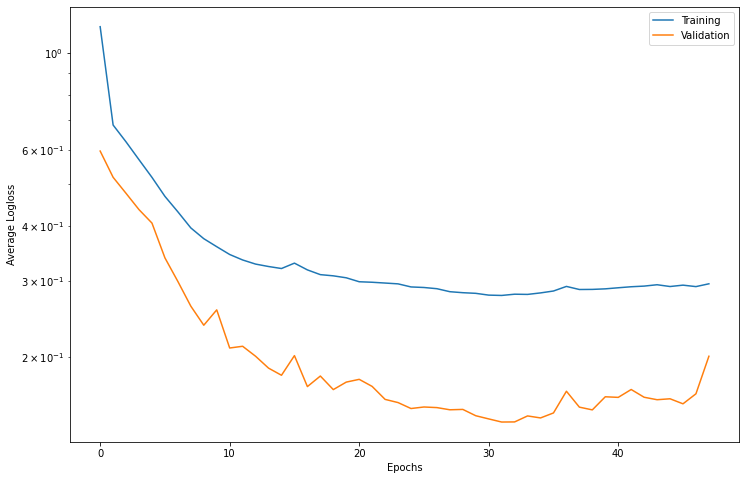

In [8]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [9]:
# Genes feature i.e. 'g-'
g_f = train_features.columns.str.contains('g-')
genes_train = data_train[:,g_f]
genes_test = data_test[:,g_f]
dim_enc = 1600
act = 'relu'
noise = 0.15
dropout = 0.1
class Autoencoder(Model):
    def __init__(self, num_inp, dim_enc):
        super(Autoencoder, self).__init__()
        # encoder function
        self.encoder = Sequential([
            layers.BatchNormalization(),
            layers.Dropout(noise),
            layers.Dense(0.5*dim_enc,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.75*dim_enc,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(dim_enc,activation=act),
        ])
        # decoder function
        self.decoder = Sequential([
            layers.Dense(0.75*dim_enc,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.5*dim_enc,activation=act),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(num_inp)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
gene_auto_encd = Autoencoder(g_f.sum(),dim_enc)
gene_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss='mse')
ae_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1E-5)
ae_early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=16, restore_best_weights=True)

hist = gene_auto_encd.fit(genes_train,genes_train,batch_size=128, verbose=1, 
                          validation_data = (genes_test,genes_test), epochs=256, 
                          shuffle=True, callbacks=[ae_early_stopping,lr_scheduler])

gene_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=5*1E-5), loss='mse')
gene_auto_encd.fit(genes_train,genes_train,batch_size=128, verbose=1, 
                   validation_data = (genes_test,genes_test), epochs=256, 
                   shuffle=True, callbacks=[ae_early_stopping])
gene_auto_encd.save('gene_fet_auto_encd')

Epoch 1/256
172/172 [==============================] - 3s 8ms/step - loss: 1.2206 - val_loss: 0.6467
Epoch 2/256
172/172 [==============================] - 1s 7ms/step - loss: 0.7519 - val_loss: 0.5632
Epoch 3/256
172/172 [==============================] - 1s 7ms/step - loss: 0.6639 - val_loss: 0.5065
Epoch 4/256
172/172 [==============================] - 1s 6ms/step - loss: 0.5962 - val_loss: 0.4649
Epoch 5/256
172/172 [==============================] - 1s 6ms/step - loss: 0.5406 - val_loss: 0.4332
Epoch 6/256
172/172 [==============================] - 1s 7ms/step - loss: 0.4978 - val_loss: 0.4161
Epoch 7/256
172/172 [==============================] - 1s 6ms/step - loss: 0.4589 - val_loss: 0.3864
Epoch 8/256
172/172 [==============================] - 1s 7ms/step - loss: 0.4321 - val_loss: 0.3836
Epoch 9/256
172/172 [==============================] - 1s 7ms/step - loss: 0.4163 - val_loss: 0.3546
Epoch 10/256
172/172 [==============================] - 1s 7ms/step - loss: 0.4068 - val_lo

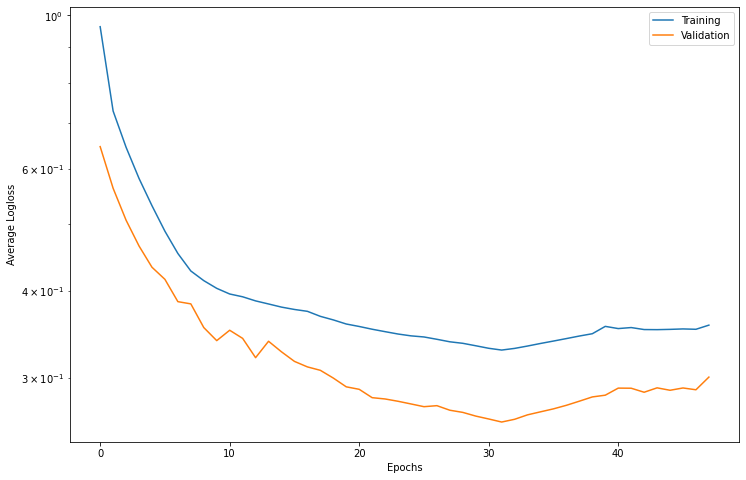

In [10]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [11]:
ae_cells_train = cell_auto_encd.encoder(cells_train).numpy()
ae_cells_test = cell_auto_encd.encoder(cells_test).numpy()
autoencoder_error = mean_squared_error(cells_test,cell_auto_encd.decoder(ae_cells_test).numpy())
print("Cells reconstruction error is " + str(autoencoder_error))

Cells reconstruction error is 0.1359665235226094


In [12]:
# Comparison with PCA
pca = PCA(n_components=50)
pca.fit(cells_train)
pca_error = mean_squared_error(cells_test,pca.inverse_transform(pca.transform(cells_test)))
print('PCA Reconstruction Error for Cells is ' + str(pca_error))

PCA Reconstruction Error for Cells is 0.2175155904767999


* Autoencoders performs well for cell features

In [13]:
ae_genes_train = gene_auto_encd.encoder(genes_train).numpy()
ae_genes_test = gene_auto_encd.encoder(genes_test).numpy()
autoencoder_error = mean_squared_error(genes_test,gene_auto_encd.decoder(ae_genes_test).numpy())
print("Genes reconstruction error is " + str(autoencoder_error))

Genes reconstruction error is 0.25370338816821875


In [14]:
# Comparison with PCA
pca = PCA(n_components=386)
pca.fit(genes_train)
pca_error = mean_squared_error(genes_test,pca.inverse_transform(pca.transform(genes_test)))
print('PCA Reconstruction Error for Genes is ' + str(pca_error))

PCA Reconstruction Error for Genes is 0.1629985903595509


* PCA performs well for gene features

In [15]:
# Replacing the data with encoded data
data_train = np.concatenate((data_train[:,~(c_f+g_f)],ae_genes_train,ae_cells_train),axis=1)
data_test = np.concatenate((data_test[:,~(c_f+g_f)],ae_genes_test,ae_cells_test),axis=1)

In [16]:
num_of_lab = train_targets_scored.shape[1]
# num_of_feat = data_train.shape[1]
# n_train = data_train.shape[0]
final_test = data_test.shape[0]


# Predicting Thresholds

p_min = 0.0005
p_max = 0.9995

# Evaluation Metric

# here we uses logloss as the given kaggle dataset asked for performing a logloss metrices

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

# Generating Seeds

num_of_seeds = 3
seeds = [34,9,18]

# Training Loop

num_of_folds = 5
y_pred = np.zeros((final_test,num_of_lab))
oof = tf.constant(0.0)
hists = []
bias = tf.keras.initializers.Constant(np.log(train_label.mean(axis=0)))
for seed in seeds:
    fold = 0
    mskf = MultilabelStratifiedKFold(n_splits=num_of_folds,shuffle=True,random_state=seed)
    for train, test in mskf.split(data_train,train_label):
        X_train = data_train[train]
        X_test = data_train[test]
        y_train = train_label[train]
        y_test = train_label[test]

        # Building Neural Network Model

        model = Sequential()
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(1536))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.7))
        model.add(layers.Dense(1024))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(512))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(num_of_lab,activation='sigmoid',bias_initializer=bias))
        model.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss=losses.BinaryCrossentropy(label_smoothing=0.001), metrics=['binary_crossentropy',logloss])
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.3, patience=5, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=24, mode='min',restore_best_weights=True)
        def scheduler(epoch,lr):
            if epoch%16<9:
                lr += np.exp(-int(epoch/16))*(0.5*1E-2)/16
            else:
                lr -= np.exp(-int(epoch/16))*(0.5*1E-2)/16
            return lr

        lr_scheduler = callbacks.LearningRateScheduler(scheduler)
        hist = model.fit(X_train,y_train, batch_size=128, epochs=192,
                         verbose=1,validation_data = (X_test,y_test),
                         callbacks=[lr_scheduler, early_stopping])
        
        model.compile(optimizer=optimizers.Adam(learning_rate=1E-5), 
                      loss=losses.BinaryCrossentropy(label_smoothing=0.001), 
                      metrics=['binary_crossentropy',logloss])
        model.fit(X_train,y_train, batch_size=128, 
                  epochs=192,verbose=1,validation_data = (X_test,y_test),
                  callbacks=[early_stopping])

        hists.append(hist)
        
        # Save Model
        model.save('AutoEncoded_seed_'+str(seed)+'_fold_'+str(fold))
        
        #Creating pickle file
        filename = 'AutoEncoded_seed_'+str(seed)+'_fold_'+str(fold)+'.pickle'
        pickle.dump(model, open(filename, 'wb'))

        # OOF Score
        y_val = model.predict(X_test)
        oof += logloss(tf.constant(y_test,dtype=tf.float32),
                       tf.constant(y_val,dtype=tf.float32))/(num_of_folds*num_of_seeds)

        # Run prediction
        y_pred += model.predict(data_test)/(num_of_folds*num_of_seeds)

        fold += 1

Epoch 1/192
138/138 [==============================] - 2s 8ms/step - loss: 0.0293 - binary_crossentropy: 0.0262 - logloss: 0.0261 - val_loss: 0.0229 - val_binary_crossentropy: 0.0199 - val_logloss: 0.0198
Epoch 2/192
138/138 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0222 - logloss: 0.0222 - val_loss: 0.0224 - val_binary_crossentropy: 0.0193 - val_logloss: 0.0192
Epoch 3/192
138/138 [==============================] - 1s 6ms/step - loss: 0.0228 - binary_crossentropy: 0.0196 - logloss: 0.0196 - val_loss: 0.0213 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0181
Epoch 4/192
138/138 [==============================] - 1s 6ms/step - loss: 0.0218 - binary_crossentropy: 0.0186 - logloss: 0.0186 - val_loss: 0.0210 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0177
Epoch 5/192
138/138 [==============================] - 1s 6ms/step - loss: 0.0213 - binary_crossentropy: 0.0180 - logloss: 0.0180 - val_loss: 0.0209 - val_binary_crossentropy: 0.01

In [ ]:
import pickle
# saving the model to the local file system


OOF score is  0.0157985613


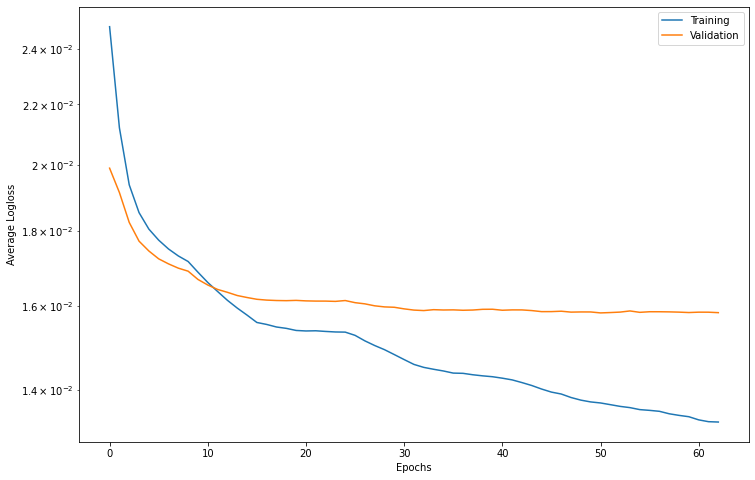

In [17]:
# Analysis of Training

tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(num_of_folds*num_of_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(num_of_folds*num_of_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(num_of_folds*num_of_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(num_of_folds*num_of_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [18]:
p_min = 0.0005
p_max = 0.9995

# Generate submission file, Clip Predictions

sub = pd.read_csv('/content/sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('/content/submission.csv', index=False)

## Conclusion

* For the given dataset it was observed that applying autoencoder the neural network model gives a logloss of 0.0128 & a val_loss of 0.0192. 

![](kaggle_score.png)